In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0
Running on TPU  ['10.0.0.2:8470']


In [2]:
import numpy as np
import pandas as pd 
import os
import time
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import math
print(tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

2.2.0


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
data_dir = dirname

/kaggle/input/chineseenglish-mt/test.en
/kaggle/input/chineseenglish-mt/vocab.zh
/kaggle/input/chineseenglish-mt/dev.zh
/kaggle/input/chineseenglish-mt/vocab.en
/kaggle/input/chineseenglish-mt/train.zh
/kaggle/input/chineseenglish-mt/dev.en
/kaggle/input/chineseenglish-mt/train.en
/kaggle/input/chineseenglish-mt/test.zh


# 构建词汇表

In [4]:

# 数据集已预处理好词汇表
def build_wordlist(path):
    word2id = {}
    id2word = {}
    with open(path, encoding = 'utf-8') as f:
        for line,word in enumerate(f):
            word2id[word.strip()] = line
            id2word[line] = word.strip()
    return word2id,id2word
    

In [5]:
word2id_zh, id2word_zh = build_wordlist(data_dir + '/vocab.zh')
word2id_en, id2word_en = build_wordlist(data_dir + '/vocab.en')

In [6]:
len(word2id_zh)

53712

In [7]:
len(word2id_en)

35028

# 构建训练集

## 统计样本长度分布

In [8]:
#统计训练样本词汇个数分布
def words_count(path):
    num_words = []
    with open(path, encoding = 'utf-8') as f:
        for line in f.readlines():
            sp = line.strip().split()
            num_words.append(len(sp))
    return num_words

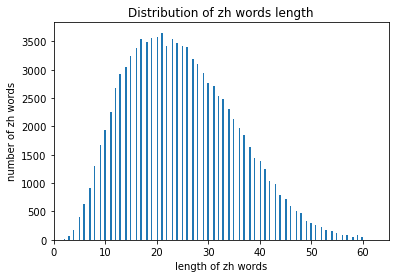

In [9]:
num_words_zh = words_count(data_dir + '/train.zh') + words_count(data_dir + '/dev.zh')

plt.hist(num_words_zh, bins=200)
plt.xlim(0, 65)
plt.ylabel("number of zh words")
plt.xlabel("length of zh words")
plt.title("Distribution of zh words length")
plt.show()

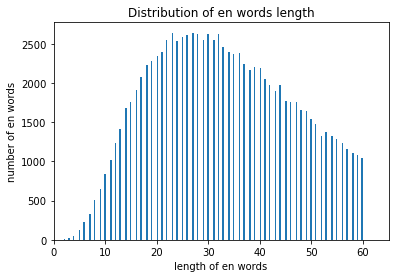

In [10]:
num_words_en = words_count(data_dir + '/train.en') + words_count(data_dir + '/dev.en')

plt.hist(num_words_en, bins=200)
plt.xlim(0, 65)
plt.ylabel("number of en words")
plt.xlabel("length of en words")
plt.title("Distribution of en words length")
plt.show()

## 训练集生成

In [11]:
max_len_en = 62
max_len_zh = 50
# 分布式训练，全局批大小
batch_size = 256
global_batch_size = batch_size * tpu_strategy.num_replicas_in_sync

In [12]:

#统计数据集大小
def data_count(path):    
    with open(path,'rb') as f:
        #统计 \n 个数（行数）
        count = 0
        while True:
            buffer = f.read(8192*1024)
            if not buffer:
                break
            count += buffer.count(bytes("\n", encoding="utf-8"))
        f.close()
        return count
    
count_train = data_count(data_dir + '/train.zh')
count_val = data_count(data_dir + '/dev.zh')
count_test = data_count(data_dir + '/test.zh')
print("训练集个数：",count_train)
print("验证集个数：",count_val)
print("测试集个数：",count_test)

训练集个数： 100000
验证集个数： 400
测试集个数： 400


In [13]:
    # 开始和结束标记
def preprocess_sentence(w):
  w = '<s> ' + w + ' </s>'
  return w

In [14]:

# 添加开始和结束标记，并填充至maxlen
def pad_data(path, mxlen, zh = 1):
    X = []
    with open(path, encoding = 'utf-8') as f:
        for line in f.readlines():
            st = line.strip('\n') #去除\n等
            w = preprocess_sentence(st) # 添加开始结束标记
            sp = w.split() # 分割为列表
            if not sp:
                continue

            x = [0] * mxlen
            # 开始标记
            index = 0
            for word in sp:
                # 控制最大长度
                if index < mxlen:
                    if zh == 1:
                        if word in word2id_zh:
                            x[index] = word2id_zh[word]
                            index += 1
                    else:
                        if word in word2id_en:
                            x[index] = word2id_en[word]
                            index += 1
                else:
                    break
            X.append(x)
    X = np.array(X)
    return X



In [15]:
train_zh = pad_data(data_dir + '/train.zh', mxlen=max_len_zh, zh = 1)
train_en = pad_data(data_dir + '/train.en', mxlen=max_len_en, zh = 0)
val_zh = pad_data(data_dir + '/dev.zh', mxlen=max_len_zh, zh = 1)
val_en = pad_data(data_dir + '/dev.en', mxlen=max_len_en, zh = 0)
test_zh = pad_data(data_dir + '/test.zh', mxlen=max_len_zh, zh = 1)
test_en = pad_data(data_dir + '/test.en', mxlen=max_len_en, zh = 0)

In [16]:
print(test_zh[0])

[    1    66    24    11    32  2535 49862     4     3   659  1469     3
  6059 14607     3  1594     4  1532   177  2071    27     4   155    28
   229   449     4   734     5     2     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [17]:
print(test_en[0])

[   1   82   36   13   11   11 2741 3756  111 7660   34    3 4512    9
    3  653    6 2140   83   60 3672 3088   13    8  113    3  672 1549
  550   17    3   62   15  186    7    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


zh2en

In [18]:
train_zh2en =  tf.data.Dataset.from_tensor_slices((train_zh, train_en)).shuffle(count_train)
# global_batch_size
train_zh2en = train_zh2en.batch(global_batch_size, drop_remainder=True)

In [19]:
val_zh2en =  tf.data.Dataset.from_tensor_slices((val_zh, val_en)).batch(global_batch_size)
# 测试集逐句
test_zh2en =  tf.data.Dataset.from_tensor_slices((test_zh, test_en))

In [20]:
# 分布式数据集
train_dataset_zh2en = tpu_strategy.experimental_distribute_dataset(train_zh2en)
val_dataset_zh2en = tpu_strategy.experimental_distribute_dataset(val_zh2en)

en2zh

In [21]:
train_en2zh =  tf.data.Dataset.from_tensor_slices((train_en, train_zh)).shuffle(count_train)
# global_batch_size
train_en2zh = train_en2zh.batch(global_batch_size, drop_remainder=True)

In [22]:
val_en2zh =  tf.data.Dataset.from_tensor_slices((val_en, val_zh)).batch(global_batch_size)
# 测试集逐句
test_en2zh =  tf.data.Dataset.from_tensor_slices((test_en, test_zh))

In [23]:
# 分布式数据集
train_dataset_en2zh = tpu_strategy.experimental_distribute_dataset(train_en2zh)
val_dataset_en2zh = tpu_strategy.experimental_distribute_dataset(val_en2zh)

# 构建模型

In [24]:
vocab_size_zh = len(word2id_zh)
vocab_size_en = len(word2id_en)

steps_per_epoch = count_train//batch_size
embedding_dim = 512
units = 1024 # GRU隐层神经元数

## 编码器

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        '''
        :vocab_size: 词汇数
        :embedding_dim: 词嵌入维度
        :enc_units: 编码器中GRU层的隐节点数
        :batch_sz: 批大小
        '''
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        '''
        embedding output:（batch size, mxlen, embedding_dim）
        gru output: (batch size, mxlen, enc_units)
        '''
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform') #均匀分布
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.dropout(x)
        
        # GRU输出和最后一个时间步的隐层状态
#         output, state, _ = self.gru(x, initial_state = hidden) #双向
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        # 隐节点零张量初始化
#         return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(2)] #双向
        return [tf.zeros((self.batch_sz, self.enc_units))]

## 注意力机制

In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        '''
            :query为编码器的最后一时间步隐层状态：(batch size, enc_units)
            :values为编码器的所有时间步的output: (batch size, mxlen, enc_units)

            :拓展hidden维度, hidden_with_time_axis:（batch size，1，enc_units）
        '''
        
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        
        '''
            attention_weights：注意力系数
            values:(batch size, mxlen, enc_units) ==>（batch size，mxlen，dense_units）
            hidden: （batch size，1，enc_units） ==> (batch size，1，dense_units)
            Broadcasting 机制张量相加 ==>（batch size，mxlen，dense_units）
            
            score，最后一个状态state 和 mxlen个时间步隐层输出output的相似度: Dense(1) ==> (batch size，mxlen，1)
        '''

        # 对 mxlen所在维度softmax，即计算 mxlen个时间步的各自概率。概率大意味着相关性更高
        # ===> (batch size, mxlen, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 = 注意力权重 * 编码器隐层输出 【对各时间步的输出加权求和】
        context_vector = attention_weights * values
        
        # (batch size, mxlen, enc_units) ==> reduce_sum ==> (batch size, enc_units)
        # 即mxlen个时间步的对应神经元值相加（mxlen个值相加），最终去除时间步维度；为了得到神经元值
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## 解码器

In [27]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.gru = tf.keras.layers.GRU(
            self.dec_units, 
            return_sequences=True,
            return_state=True, 
            recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 使用上次隐层state计算注意力上下文，第一次使用编码器最后output
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x : (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        x = self.dropout(x)

        # 将上一解码预测结果x（fc后） 和上下文向量结合作为本次GRU输入
        # (batch_size, 1, embedding_dim + enc_units)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # output: (batch_size, 1, dec_units) 单个word预测
        # state:  (batch_size, dec_units)
        output, state = self.gru(x)

        # (batch_size * 1, dec_units)
        output = tf.reshape(output, (-1, output.shape[2])) # -1代表未知

        # (batch_size, vocab_size)
        x = self.fc(output)

        return x, state, attention_weights


# 模型训练

In [28]:
with tpu_strategy.scope():

    # 中译英
    encoder_zh2en = Encoder(vocab_size_zh, embedding_dim, units, batch_size)
    decoder_zh2en = Decoder(vocab_size_en, embedding_dim, units, batch_size)

    # 英译中
    encoder_en2zh = Encoder(vocab_size_en, embedding_dim, units, batch_size)
    decoder_en2zh = Decoder(vocab_size_zh, embedding_dim, units, batch_size)



In [29]:
with tpu_strategy.scope():
    # 优化器
    optimizer = tf.keras.optimizers.Adam()
#     train_acc = tf.metrics.SparseCategoricalAccuracy()

    # 损失函数
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    def loss_function(real, pred):
        # real !=0 的返回 True
        mask = tf.math.logical_not(tf.math.equal(real, 0)) 
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype) # cast类型转换
        # mask为True，即real != 0时，loss不变；否则loss为0
        loss_ *= mask
        # return tf.reduce_mean(loss_)
        return tf.nn.compute_average_loss(loss_, global_batch_size=global_batch_size)
    
    checkpoint_dir = './check'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                     encoder=encoder_zh2en,
                                     decoder=decoder_zh2en)

In [30]:
with tpu_strategy.scope():
    class myModel():
        # task = 1 : 中译英
        def __init__(self, task, epochs):
            self.task = task
            self.EPOCHS = epochs
            
            if self.task == 1:
                self.encoder = encoder_zh2en
                self.decoder = decoder_zh2en
                self.train_dataset = train_dataset_zh2en
                self.val_dataset = val_dataset_zh2en
            else:
                self.encoder = encoder_en2zh
                self.decoder = decoder_en2zh
                self.train_dataset = train_dataset_en2zh
                self.val_dataset = val_dataset_en2zh
                
        # 一次训练
        def train_step(self, inp, targ, enc_hidden):
            '''
            inp: input sequence
            targ: 翻译目标 sequence
            enc_hidden: 编码器初始state

            '''
            with tf.GradientTape() as tape:
                enc_output, enc_hidden = self.encoder(inp, enc_hidden)
                # 编码器最后一个隐层state作为解码器第一个隐层state
                dec_hidden = enc_hidden

                # 起始字符<s>
                # (batch_size, 1)
                dec_input = tf.expand_dims([word2id_zh['<s>']] * batch_size, 1)
                
                # 教师强制，将目标词作为下一个输入
                for t in range(1, targ.shape[1]):
                    # x, state, attention_weights
                    pre, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
                    if t == 1:
                        loss = loss_function(targ[:, t], pre)
                    loss += loss_function(targ[:, t], pre)

                    # 在训练时，每次解码器的输入并不是上次解码器的输出，而是样本目标语言对应单词
                    dec_input = tf.expand_dims(targ[:, t], 1)

                # 所有单词的平均损失值
                # targ.shape[1] = 60或40
                batch_loss = loss / targ.shape[1]

                # 模型变量包括编码器和解码器
                variables = self.encoder.trainable_variables + self.decoder.trainable_variables

                # 计算损失函数关于自变量（模型参数）的梯度
                gradients = tape.gradient(loss, variables)
                # 根据梯度更新参数
                optimizer.apply_gradients(zip(gradients, variables))

            return batch_loss

        # 一次验证
        def val_step(self, inp, targ, enc_hidden):

            enc_output, enc_hidden = self.encoder(inp, enc_hidden)
            dec_hidden = enc_hidden
            # <s> 在两个词汇表索引相同
            dec_input = tf.expand_dims([word2id_zh['<s>']] * batch_size, 1)
            
            # 非教师强制
            for t in range(1, targ.shape[1]):
                pre, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)

                if t == 1:
                      loss = loss_function(targ[:, t], pre)
                loss += loss_function(targ[:, t], pre)
                
                pre_argmax = tf.argmax(pre, axis = 1)
                dec_input = tf.expand_dims(pre_argmax, 1)

            # 所有单词的平均损失值
            batch_loss = loss/targ.shape[1]
            return batch_loss


        # TPU
        # tf.distribute.ReduceOp.SUM 将各节点放缩损失相加
        @tf.function
        def distributed_train_step(self, inp, targ, enc_hidden):
            assert tf.distribute.get_replica_context() is None
            per_replica_losses = tpu_strategy.experimental_run_v2(self.train_step, args=(inp, targ, enc_hidden))
            return tpu_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,axis=None)

        @tf.function
        def distributed_val_step(self, inp, targ, enc_hidden):
            assert tf.distribute.get_replica_context() is None
            per_replica_losses = tpu_strategy.experimental_run_v2(self.val_step, args=(inp, targ, enc_hidden))
            return tpu_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,axis=None)
        
        # 批训练
        def training(self):
            print('Start Time {}\n'.format(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())))
            for epoch in range(self.EPOCHS):
                start = time.time()
                print(f'Epoch {epoch + 1}/{self.EPOCHS}')

                # 初始化隐藏层和损失值
                enc_hidden = self.encoder.initialize_hidden_state()
                total_loss = 0.0
                num_batch = 0
                
                for inp, targ in self.train_dataset:
                    batch_loss = self.distributed_train_step(inp, targ, enc_hidden)
                    total_loss += batch_loss

                    # 每50次验证集测试,并显示模型损失值
                    if num_batch % 30 == 0:
                        total_val_loss = 0.0
                        
                        for x in self.val_dataset:
                            inp_val, targ_val = x
                            val_loss = self.distributed_val_step(inp, targ, enc_hidden)
                            total_val_loss += val_loss

                        print('Epoch {} Batch {} Training Loss {:.4f}. Validation Loss {:.4f}.'.format(
                                                                    epoch + 1,
                                                                    num_batch,
                                                                    batch_loss,
                                                                    val_loss))

                    num_batch += 1

                # 每次迭代保存一次数据
                # checkpoint.save(file_prefix=checkpoint_prefix)

                # 显示每次迭代的损失值和消耗时间
                print('Epoch {} Average  Training Loss {:.4f}. Time {} sec.\n'.format(epoch + 1,
                                                    total_loss / num_batch,
                                                    time.time() - start))
        # 测试单句
        def test_step(self, inp, targ):
            # 中译英
            if self.task == 1:
                # 目标
                reference = [[id2word_en[x] for x in targ.numpy() if x != 0 and x != 2]]
                # 原句
                sentence = [id2word_zh[x] for x in inp.numpy() if x != 0]
                # 注意力图 (result,sentence)
                attention_plot = np.zeros((max_len_en, max_len_zh))
                id2word = id2word_en
            # 英译中
            else:
                reference = [[id2word_zh[x] for x in targ.numpy() if x != 0 and x != 2]]
                sentence = [id2word_en[x] for x in inp.numpy() if x != 0]
                attention_plot = np.zeros((max_len_zh, max_len_en))
                id2word = id2word_zh

            # 翻译结果
            result = []

            # No Batch
#             hidden = [tf.zeros((1, units)) for i in range(2)]
            hidden = [tf.zeros((1, units))]
            inputs = tf.expand_dims(inp, 0)

            enc_output, enc_hidden = self.encoder(inputs, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([word2id_zh['<s>']], 0)
            result.append('<s>')

            # 非教师强制
            for t in range(targ.shape[0]):
                pre, dec_hidden, attention_weights = self.decoder(dec_input, dec_hidden, enc_output)
                # 保留注意力权重用于绘制注意力图
                attention_weights = tf.reshape(attention_weights, (-1, ))
                attention_plot[t] = attention_weights.numpy()

                # 预测值对应字符记录在result
                pre_id = tf.argmax(pre[0]).numpy()
                if pre_id != 2 and pre_id != 0:
                    result.append(id2word[pre_id])
                else:
                    break

                # 将上次预测值作为下次输入
                dec_input = tf.expand_dims([pre_id], 0)

            bleu_1 = sentence_bleu(reference, result, weights=(1, 0, 0, 0))
            bleu_2 = sentence_bleu(reference, result, weights=(0, 1, 0, 0))
            bleu_3 = sentence_bleu(reference, result, weights=(0, 0, 1, 0))
            bleu_4 = sentence_bleu(reference, result, weights=(0, 0, 0, 1))
            bleu = math.exp(bleu_1 + bleu_2 + bleu_3 + bleu_4)

            return result, sentence, reference, bleu, attention_plot

In [31]:
# 下载--解压--移动字体文件
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!rm "simhei.zip"
!mv SimHei.ttf /usr/share/fonts/truetype/

--2020-07-13 15:56:41--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  41.7MB/s    in 0.2s    

2020-07-13 15:56:41 (41.7 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      


In [32]:
with tpu_strategy.scope():
    import matplotlib.ticker as ticker
    import matplotlib.font_manager as fm
    path = '/usr/share/fonts/truetype/SimHei.ttf'
    fontprop = fm.FontProperties(fname=path, size=14)

    # 绘制注意力图
    def plot_attention(attention, sentence, predicted_sentence):
        fig = plt.figure(figsize=(len(sentence)/3,len(predicted_sentence)/3))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attention, cmap='viridis')

        ax.set_xticklabels([''] + sentence, rotation=90, fontproperties=fontprop)
        ax.set_yticklabels([''] + predicted_sentence, fontproperties=fontprop)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.show()

In [33]:
with tpu_strategy.scope():
    model_z2e = myModel(1, 10) # 中译英，15 epochs
    model_z2e.training()

Start Time 2020-07-13 15:56:44

Epoch 1/10
Epoch 1 Batch 0 Training Loss 5.8646. Validation Loss 5.8576.
Epoch 1 Batch 30 Training Loss 3.7321. Validation Loss 3.7179.
Epoch 1 Average  Training Loss 3.9498. Time 162.63054728507996 sec.

Epoch 2/10
Epoch 2 Batch 0 Training Loss 3.7114. Validation Loss 3.7002.
Epoch 2 Batch 30 Training Loss 3.6840. Validation Loss 3.6719.
Epoch 2 Average  Training Loss 3.7166. Time 27.97692036628723 sec.

Epoch 3/10
Epoch 3 Batch 0 Training Loss 3.6899. Validation Loss 3.6784.
Epoch 3 Batch 30 Training Loss 3.7232. Validation Loss 3.7107.
Epoch 3 Average  Training Loss 3.7161. Time 28.032045602798462 sec.

Epoch 4/10
Epoch 4 Batch 0 Training Loss 3.6626. Validation Loss 3.6508.
Epoch 4 Batch 30 Training Loss 3.7591. Validation Loss 3.7467.
Epoch 4 Average  Training Loss 3.7170. Time 27.937872648239136 sec.

Epoch 5/10
Epoch 5 Batch 0 Training Loss 3.7314. Validation Loss 3.7199.
Epoch 5 Batch 30 Training Loss 3.6925. Validation Loss 3.6802.
Epoch 5 Avera

中译英


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


原句： ['<s>', '但', '他', '是', '一个', '硬', '骨', '的', ',', '面对', '风险', ',', '从不', '模棱两可', ',', '唯一', '的', '追求', '就是', '站在', '国家', '的', '利益', '上', '作出', '正确', '的', '选择', '.', '</s>']
目标： ['<s>', 'but', 'he', 'is', 'a', 'a', 'tough', 'fellow', 'who', 'displays', 'not', 'the', 'slightest', 'in', 'the', 'face', 'of', 'risks', ';', 'his', 'sole', 'pursuit', 'is', 'to', 'make', 'the', 'correct', 'choice', 'based', 'on', 'the', 'state', "'s", 'interests', '.']
结果： ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
BLEU： 21.7445919222742


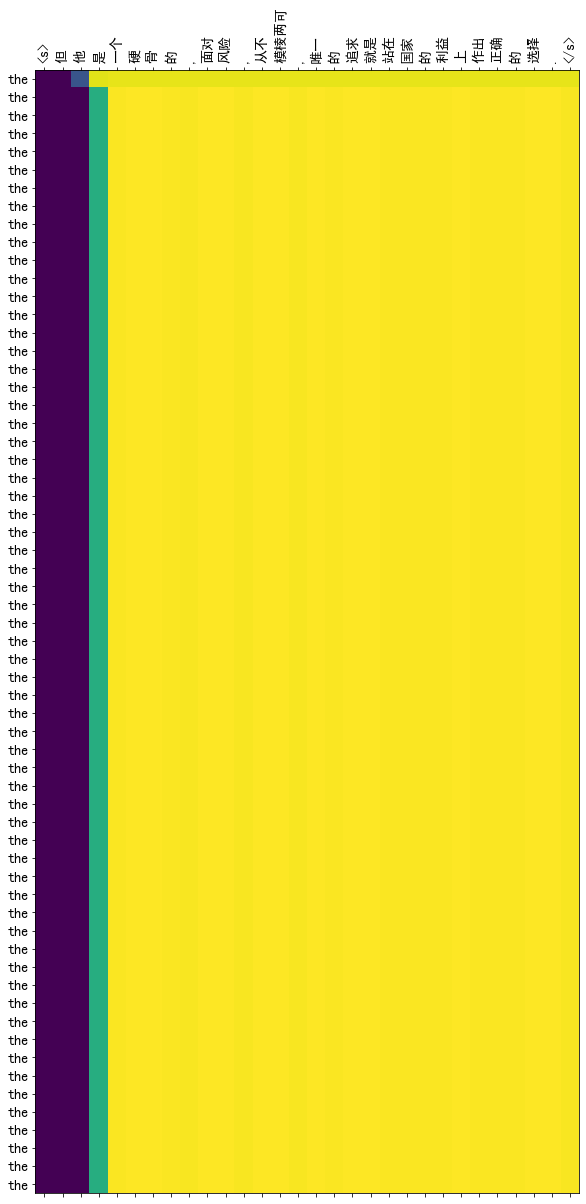

原句： ['<s>', '此前', '《', '纽约', '时报', '》', '撰文', '说', ',', '这是', '10', '年', '来', '美国', '巴尔干', '政策', '最', '辉煌', '的', '一', '笔', ',', '武力', '是', '巴尔干', '能够', '的', '唯一', '语言', '.', '</s>']
目标： ['<s>', 'a', 'previous', 'new', 'york', 'times', 'article', 'said', 'that', 'this', 'was', 'the', 'most', 'glorious', 'move', 'in', 'us', 'balkan', 'policy', 'in', 'over', '10', 'years', ',', 'and', 'that', 'armed', 'force', 'was', 'the', 'only', 'language', 'that', 'the', 'balkans', 'understand', '.']
结果： ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
BLEU： 21.402164536795475


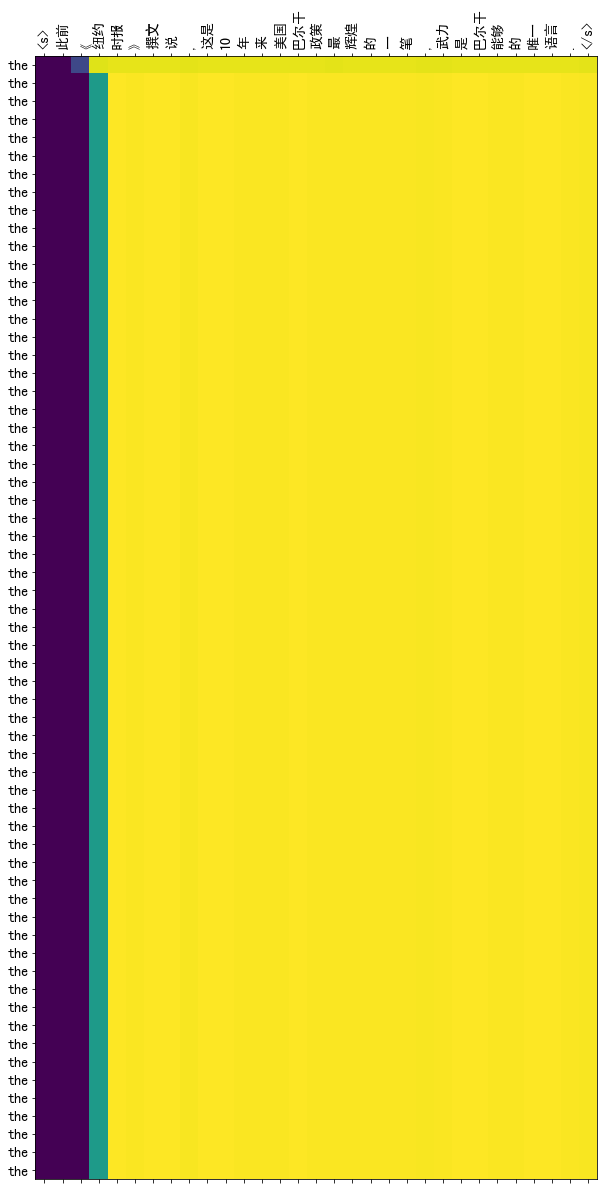

原句： ['<s>', '否则', ',', '在', '成果', '不多', ',', '质量', '不高', ',', '赢利', '能力', '有限', '的', '条件', '下', ',', '观念', '普及', '得', '再', '好', ',', '能够', '解决', '的', '问题', '总是', '有限', '的', '.', '</s>']
目标： ['<s>', 'otherwise', ',', 'in', 'a', 'situation', 'in', 'which', 'the', 'number', 'of', 'research', 'achievements', 'to', 'be', 'patented', 'is', 'limited', ';', 'their', 'quality', 'is', 'poor', ',', 'and', 'their', 'capability', 'to', 'generate', 'profits', 'is', 'limited', ',', 'problems', 'that', 'can', 'be', 'solved', 'are', 'always', 'limited', 'even', 'though', 'patent', 'conceptions', 'are', 'so', 'well', 'popularized', '.']
结果： ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the

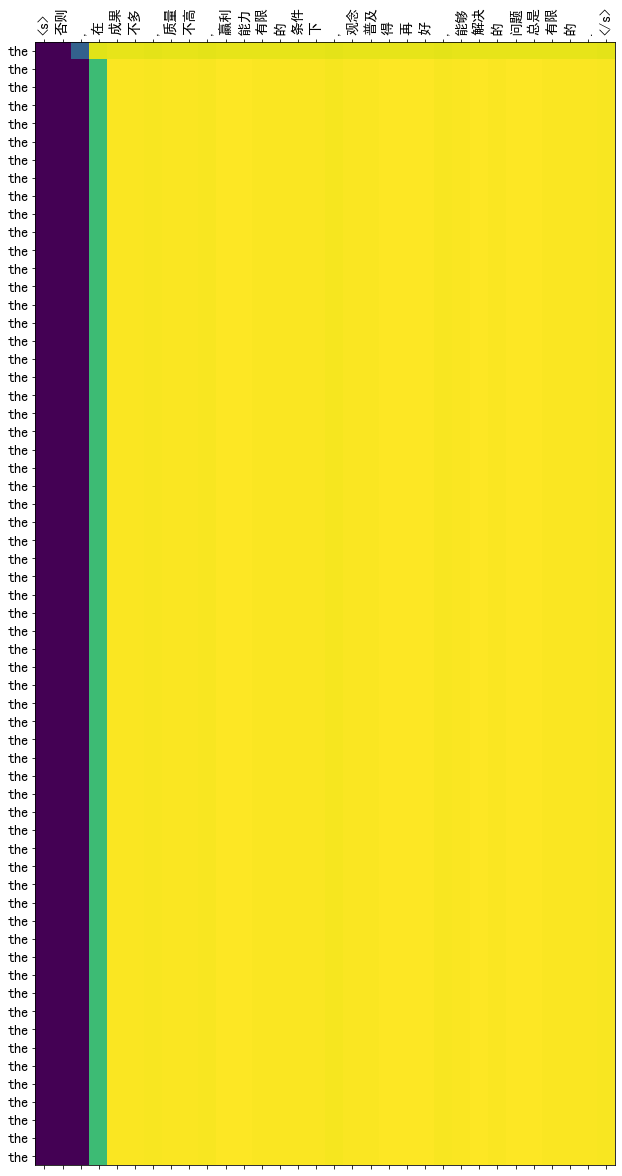

原句： ['<s>', '根据', '世贸', '组织', '的', '有关', '规定', ',', '发展中国家', '将', '在', '一些', '方面', '享受', '不同于', '发达国家', '的', '差别', '和', '优惠待遇', '.', '</s>']
目标： ['<s>', 'according', 'to', 'the', 'relevant', 'wto', 'provisions', ',', 'developing', 'countries', 'will', 'in', 'some', 'respects', 'enjoy', 'differentials', 'and', 'favored', 'treatment', 'that', 'are', 'different', 'from', 'the', 'developed', 'countries', '.']
结果： ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
BLEU： 21.065129596240293


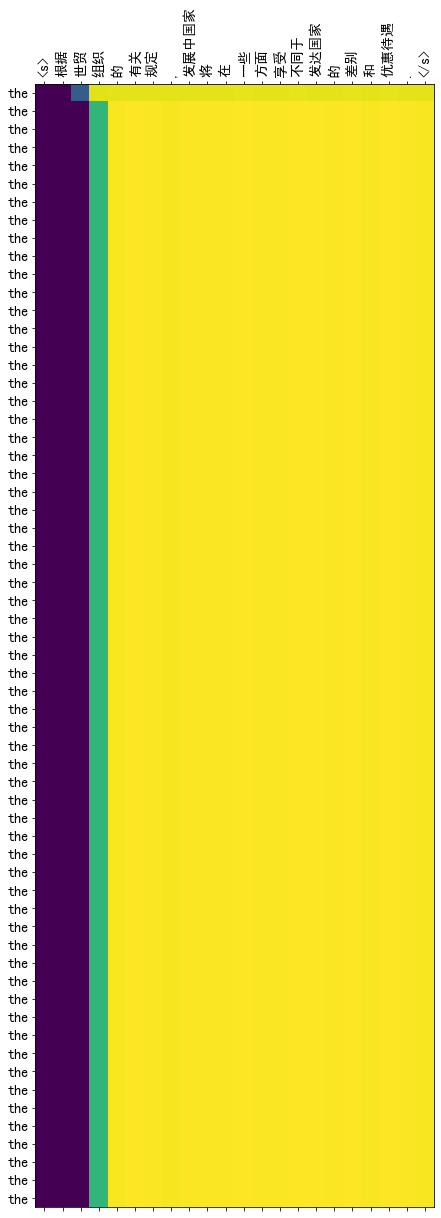

原句： ['<s>', '据悉', ',', '此前', '中国', '曾多次', '表明', '有关', '同', '八', '国', '集团', '关系', '问题', '的', '立场', '.', '</s>']
目标： ['<s>', 'it', 'is', 'learned', 'that', 'china', 'has', 'on', 'many', 'occasions', 'previously', 'made', 'known', 'its', 'stand', 'on', 'its', 'relations', 'with', 'the', 'g', '-', '8', '.']
结果： ['the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
BLEU： 20.733402181985067


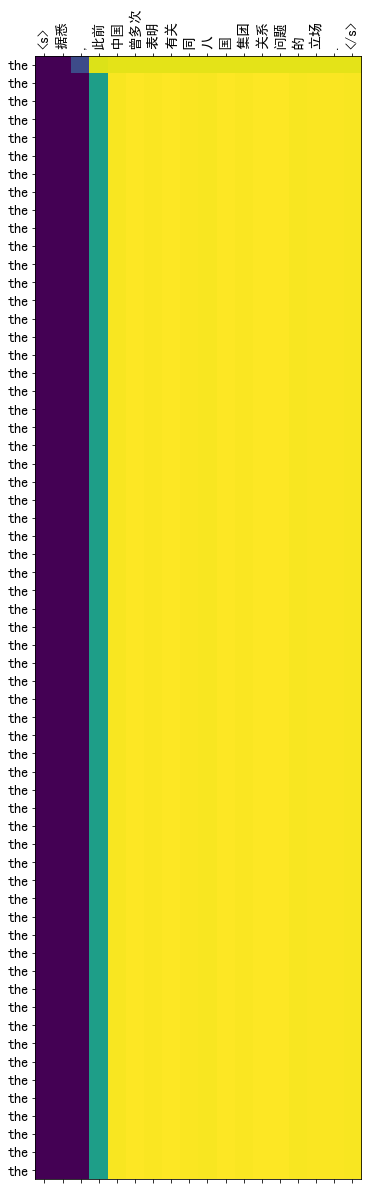

[21.7445919222742, 21.402164536795475, 20.733402181985067, 21.065129596240293, 20.733402181985067]


In [35]:
with tpu_strategy.scope():
    bleus = []
    print('中译英')
    for _, (inp, targ) in enumerate(test_zh2en.take(5)):
        res, sent, tar, bleu, atten = model_z2e.test_step(inp, targ)
        bleus.append(bleu)
        print('原句：',sent)
        print('目标：',tar[0])
        print('结果：',res[1:])
        print('BLEU：',bleu)
        plot_attention(atten[:len(res[1:]), :len(sent)], sent, res[1:])
    print(bleus)
    # plot_attention(attentions[0][:len(results[0]), :len(sentences[0])], sentences[0], results[0])